Today we are solving three questions:

Can you describe the vibe of each Seattle neighborhood using listing descriptions?

What are the busiest times of the year to visit Seattle? By how much do prices spike?

Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

Q1: Can you describe the vibe of each Seattle neighborhood using listing descriptions?

This seems to be wanting to figure out keywords within the data set.

Lets install Libraries

In [96]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import sqlite3
from googletrans import Translator
from tqdm import tqdm
import duckdb as dbu
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Step 1: clean up data

In [5]:
lis_c = pd.read_csv(r'calendar.csv')
lis_l = pd.read_csv(r'listings.csv')
lis_r = pd.read_csv(r'reviews.csv')
lis_c.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
lis_l.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [7]:
lis_r.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [8]:
lis_c.columns.unique()

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [9]:
lis_l.columns.unique()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [10]:
lis_r.columns.unique()

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [11]:
lis_l.info()
lis_l.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64

In [12]:
lis_c.info()
lis_c.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


listing_id         0
date               0
available          0
price         459028
dtype: int64

In [13]:
lis_r.info()
lis_r.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

There are some nulls which could be concerning and skew our results however it should be relatively minimal if they are evenly seperated by the neighborhoods. Perhaps we can do a test: one for outliers shaving off five or one percent of comments and a regular test.

Step 2: join csv with necessary details for the comment route

In [35]:
%%sql
SELECT r.comments
FROM read_csv_auto('reviews.csv') AS r
WHERE r.comments IS NOT NULL AND r.comments != 'None'

,comments
0,Cute and cozy place. Perfect location to every...
1,Kelly has a great room in a very central locat...
2,"Very spacious apartment, and in a great neighb..."
3,Close to Seattle Center and all it has to offe...
4,Kelly was a great host and very accommodating ...
...,...
84827,The description and pictures of the apartment ...
84828,We had an excellent stay. It was clean and com...
84829,"Gran ubicación, cerca de todo lo atractivo del..."
84830,"Very good apartement, clean and well sized. Si..."


Some of the comments are not translated in english so lets translate it and put it back into our csv.:

In [36]:
translator = Translator()
comments = df_sql2['comments']
translated = []
for text in tqdm(comments):
    try:
        translated.append(translator.translate(text, dest='en').text)
    except:
        translated.append('')

100%|██████████| 84832/84832 [00:00<00:00, 625813.37it/s]


Join the two csvs

In [37]:
%%sql
SELECT
    l.neighbourhood,
    r.comments
FROM
    'listings.csv' AS l
JOIN
    'reviews.csv' AS r
ON
    l.id = r.listing_id
WHERE
    r.comments IS NOT NULL AND r.comments != 'None' AND r.comments != '';

,neighbourhood,comments
0,Lower Queen Anne,Cute and cozy place. Perfect location to every...
1,Lower Queen Anne,Kelly has a great room in a very central locat...
2,Lower Queen Anne,"Very spacious apartment, and in a great neighb..."
3,Lower Queen Anne,Close to Seattle Center and all it has to offe...
4,Lower Queen Anne,Kelly was a great host and very accommodating ...
...,...,...
84827,Green Lake,Staying with Sierra in Greenlake was a wonderf...
84828,Green Lake,非常好的房东，贴心地准备了交通地图，旅游指南，房间设施齐全，地理位置好，一次非常好的住宿体验...
84829,Green Lake,"we missed Sierra and Ivan, as they were on a t..."
84830,Green Lake,Sierra and Ivan were great hosts! They left a ...


In [57]:
stop_words = set(stopwords.words('english')) #Introduce stop words to not mess with count
neighborhood_keywords = {}

for neighborhood in df_sql1['neighbourhood'].unique():
    comments = df_sql1[df_sql1['neighbourhood'] == neighborhood]['comments']
    text = ' '.join(comments).lower()
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha() and word not in stop_words]

    word_counts = Counter(words)
    neighborhood_keywords[neighborhood] = word_counts.most_common(10)  # top 10 keywords

In [58]:
for n, keywords in neighborhood_keywords.items():
    print(f"\n🔹 {n} — Top keywords:")
    for word, count in keywords:
        print(f"   {word}: {count}")


🔹 Lower Queen Anne — Top keywords:
   great: 1524
   seattle: 1234
   stay: 1201
   apartment: 1172
   place: 1057
   us: 892
   location: 876
   clean: 690
   would: 661
   serina: 612

🔹 Minor — Top keywords:
   great: 3642
   stay: 3131
   place: 2723
   seattle: 2455
   us: 1934
   house: 1839
   clean: 1796
   would: 1573
   location: 1561
   nice: 1421

🔹 Wallingford — Top keywords:
   great: 2810
   stay: 2455
   house: 1826
   place: 1780
   seattle: 1683
   us: 1380
   comfortable: 1298
   clean: 1230
   location: 1183
   home: 1168

🔹 Capitol Hill — Top keywords:
   great: 7359
   place: 5113
   stay: 5006
   location: 4093
   seattle: 3783
   apartment: 3749
   clean: 2981
   would: 2855
   us: 2794
   host: 2501

🔹 Ravenna — Top keywords:
   stay: 808
   great: 699
   place: 552
   seattle: 437
   us: 422
   would: 378
   clean: 373
   nice: 364
   comfortable: 353
   neighborhood: 329

🔹 Ballard — Top keywords:
   great: 5062
   stay: 4647
   place: 3397
   ballard: 3028


Didn't give us the results wwe wanted so we wil try description:

In [84]:
%%sql
SELECT l.description
FROM read_csv_auto('listings.csv') AS l
WHERE l.description IS NOT NULL AND l.description != 'None'

,description
0,Make your self at home in this charming one-be...
1,Chemically sensitive? We've removed the irrita...
2,New modern house built in 2013. Spectacular s...
3,A charming apartment that sits atop Queen Anne...
4,Cozy family craftman house in beautiful neighb...
...,...
3813,Our 3BR/2BA house boasts incredible views of t...
3814,800 square foot 1 bedroom basement apartment w...
3815,"Very comfortable lower unit. Quiet, charming m..."
3816,Cozy studio condo in the heart on Madison Park...


In [85]:
translator = Translator()
description = df_sql3['description']
translated = []
for text in tqdm(description):
    try:
        translated.append(translator.translate(text, dest='en').text)
    except:
        translated.append('')

100%|██████████| 3818/3818 [00:00<00:00, 635798.34it/s]


In [86]:
%%sql
SELECT
    l.neighbourhood,
    l.description
FROM
    'listings.csv' AS l
WHERE
    l.description IS NOT NULL AND l.description != 'None' AND l.description != '';

,neighbourhood,description
0,Queen Anne,Make your self at home in this charming one-be...
1,Queen Anne,Chemically sensitive? We've removed the irrita...
2,Queen Anne,New modern house built in 2013. Spectacular s...
3,Queen Anne,A charming apartment that sits atop Queen Anne...
4,Queen Anne,Cozy family craftman house in beautiful neighb...
...,...,...
3813,Fremont,Our 3BR/2BA house boasts incredible views of t...
3814,Portage Bay,800 square foot 1 bedroom basement apartment w...
3815,None,"Very comfortable lower unit. Quiet, charming m..."
3816,None,Cozy studio condo in the heart on Madison Park...


In [87]:
stop_words = set(stopwords.words('english')) #Introduce stop words to not mess with count
neighborhood_keywords = {}

for neighborhood in df_sql4['neighbourhood'].unique():
    description = df_sql4[df_sql4['neighbourhood'] == neighborhood]['description']
    text = ' '.join(description).lower()
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha() and word not in stop_words]

    word_counts = Counter(words)
    neighborhood_keywords[neighborhood] = word_counts.most_common(10)  # top 10 keywords

In [88]:
for n, keywords in neighborhood_keywords.items():
    print(f"\n🔹 {n} — Top keywords:")
    for word, count in keywords:
        print(f"   {word}: {count}")


🔹 Queen Anne — Top keywords:
   queen: 332
   seattle: 248
   anne: 240
   room: 212
   home: 194
   downtown: 158
   space: 156
   kitchen: 143
   bedroom: 141
   apartment: 134

🔹 None — Top keywords:

🔹 Ballard — Top keywords:
   ballard: 361
   room: 293
   seattle: 193
   kitchen: 191
   home: 184
   private: 166
   house: 166
   bed: 166
   bedroom: 156
   downtown: 153

🔹 Phinney Ridge — Top keywords:
   room: 69
   house: 60
   phinney: 54
   seattle: 54
   home: 52
   private: 51
   ridge: 49
   bedroom: 48
   neighborhood: 47
   kitchen: 43

🔹 Fremont — Top keywords:
   fremont: 218
   seattle: 167
   room: 154
   kitchen: 143
   apartment: 127
   bed: 111
   bedroom: 110
   full: 105
   downtown: 96
   home: 95

🔹 Lower Queen Anne — Top keywords:
   seattle: 141
   space: 104
   queen: 100
   needle: 78
   apartment: 73
   anne: 69
   center: 68
   walk: 66
   room: 63
   great: 61

🔹 Westlake — Top keywords:
   seattle: 18
   lake: 13
   union: 11
   view: 9
   downtown: 9

A1: You can not find out the vibe of a neighborhood based on description. I believe this is mainly when a person would be describing the Air BNB, they wouldnt be describing specifically where it is but what and how it is. The way I would be thinking about it is that if I was a lister, I would want to show off my house rather than its location. The only caveat would be if the house is near somewhere significant. The only main 'whereabouts' you will receive is that it is either in or near a college campus, downtown, 'nature', or a destination. It definitely can not describe the 'vibe' of the place.

Q2:What are the busiest times of the year to visit Seattle? By how much do prices spike?


In [130]:
%%sql
SELECT
    c.date,
    SUM(
        CASE WHEN c.available = 'f' THEN 1 ELSE 0 END
    )
     AS total_booked
FROM
    'calendar.csv' AS c
WHERE
    c.available IS NOT NULL
GROUP BY
    c.date
ORDER BY
    c.date;

,date,total_booked
0,2016-01-04,2083.0
1,2016-01-05,1951.0
2,2016-01-06,1992.0
3,2016-01-07,2042.0
4,2016-01-08,2036.0
...,...,...
360,2016-12-29,983.0
361,2016-12-30,978.0
362,2016-12-31,959.0
363,2017-01-01,896.0


In [131]:
%%sql
COPY (
    SELECT *
    FROM df_sql7)
TO 'SQL PowerIB PT1.csv' (FORMAT CSV, HEADER);

,Count
0,365


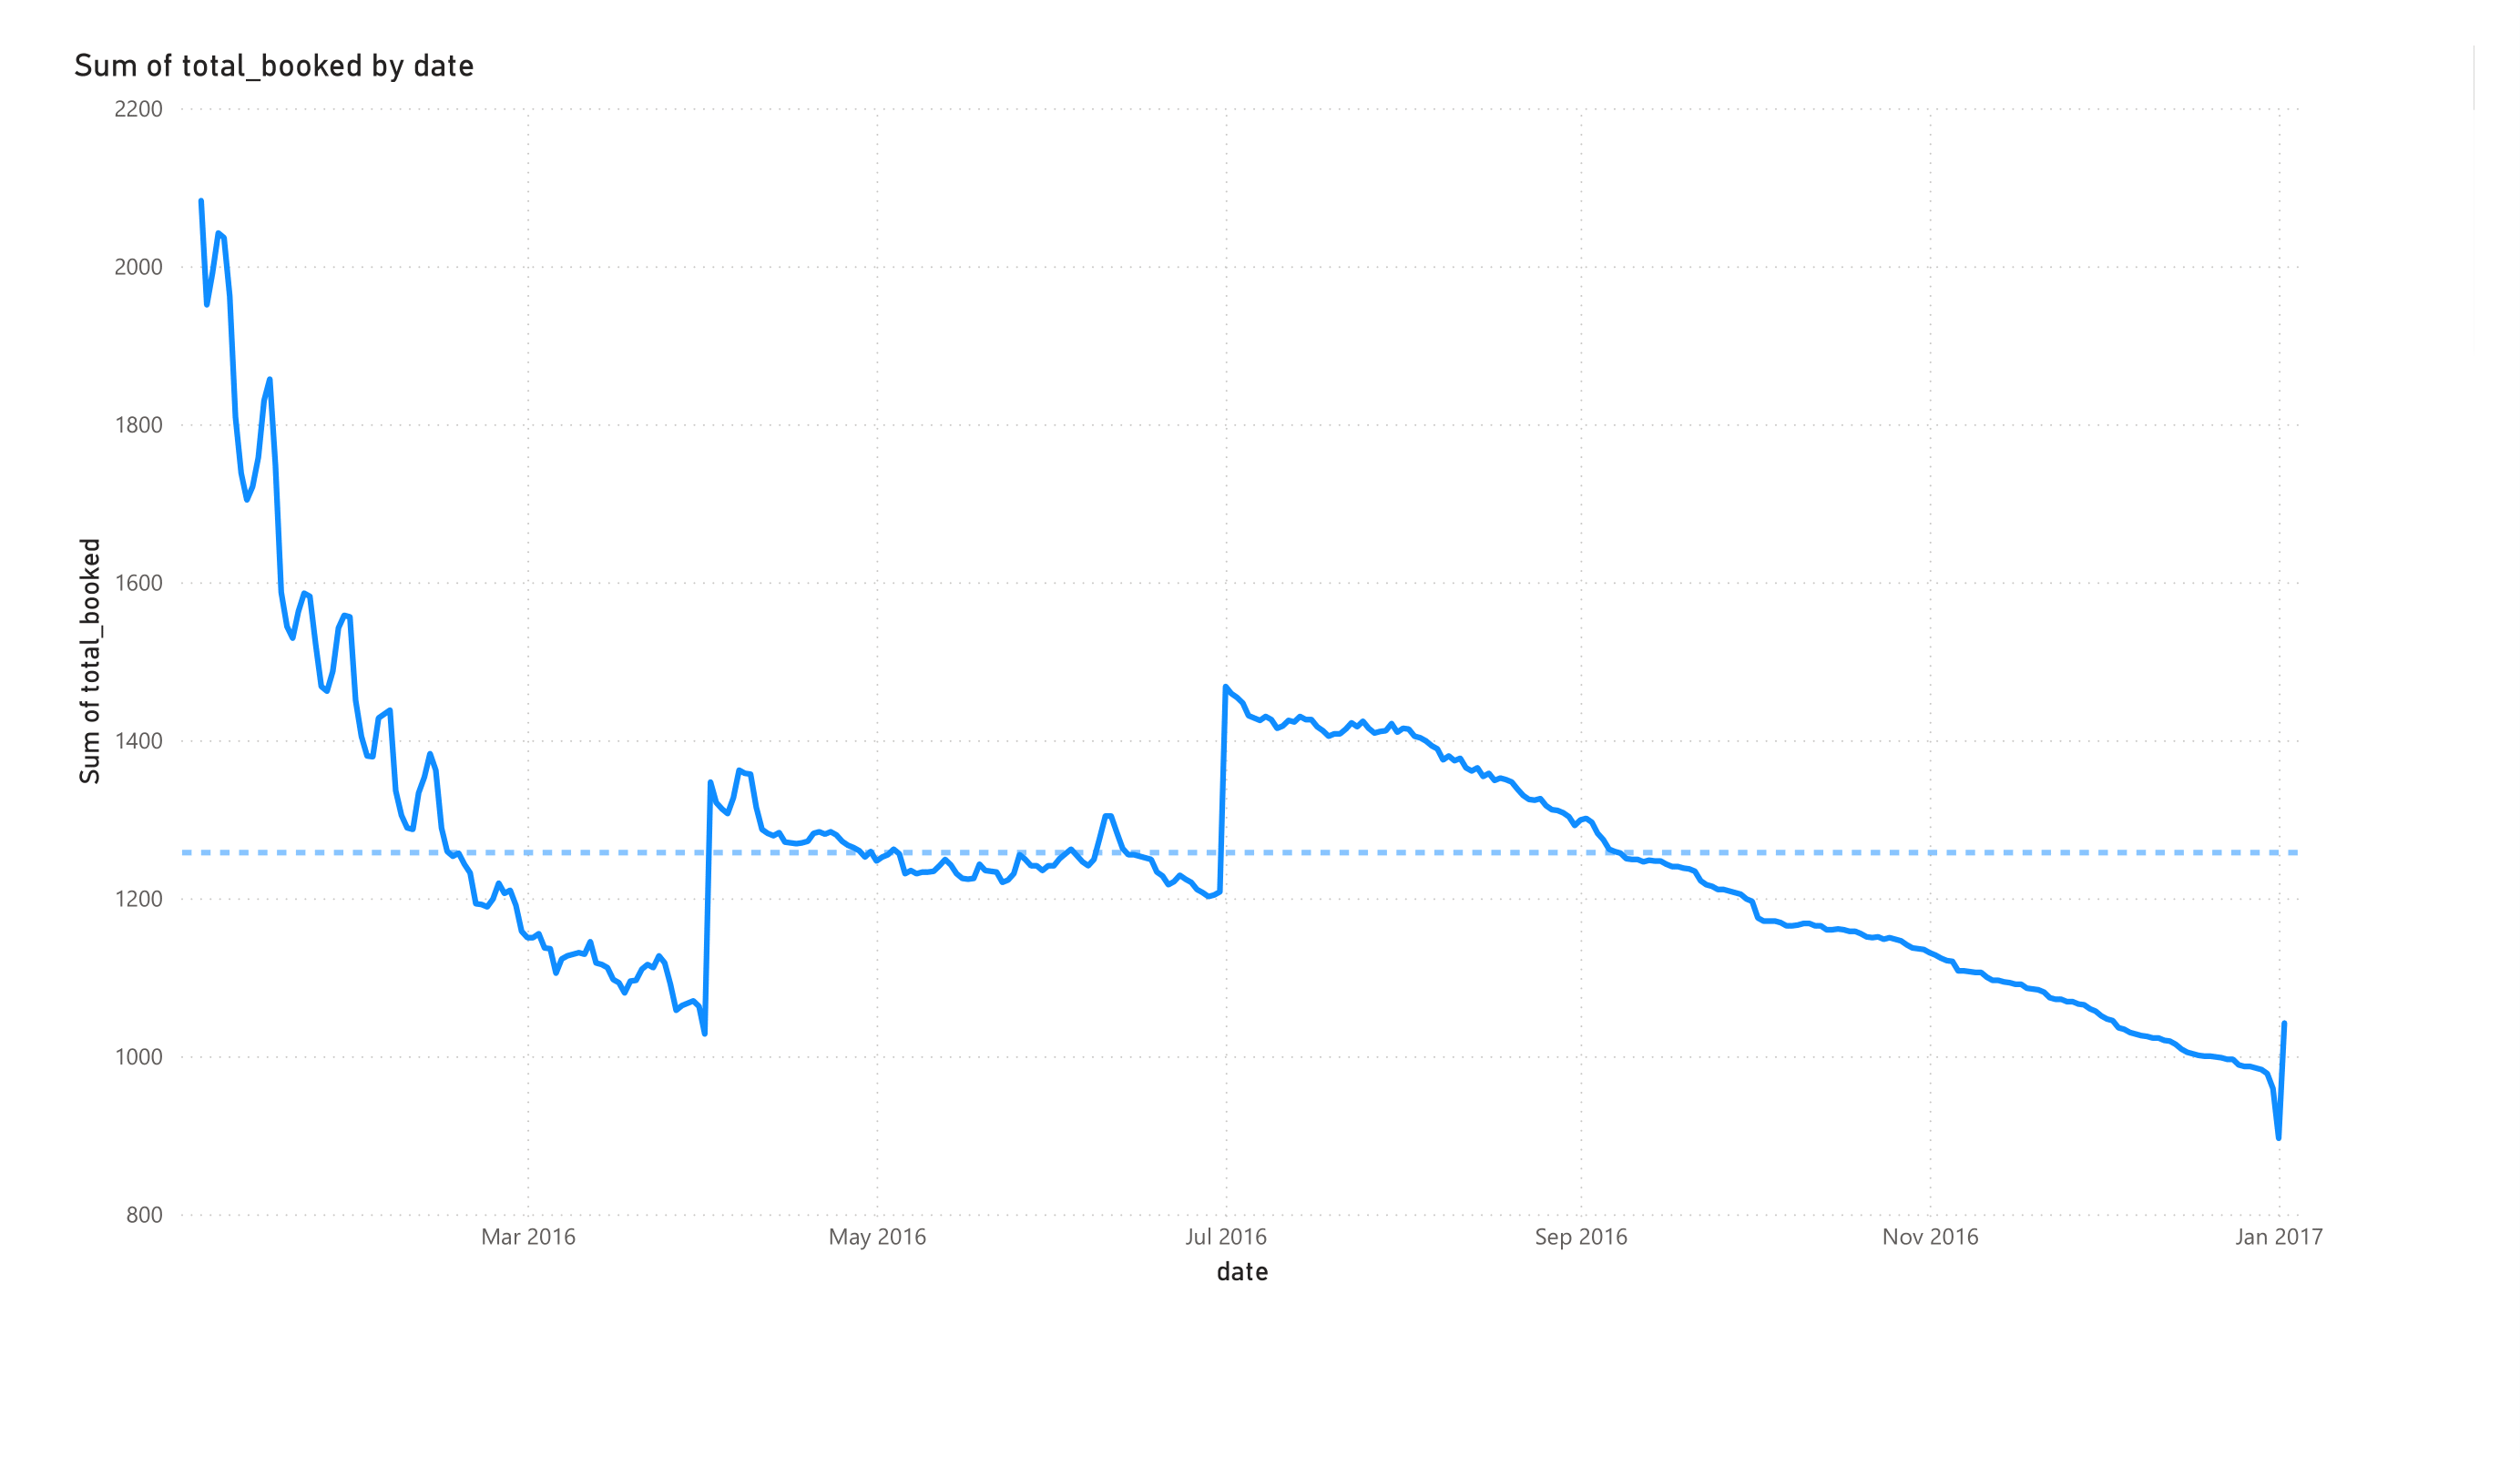

In [132]:
from IPython.display import Image, display

display(Image(filename='Untitled-1.png'))

A2P1: Lets see. From our data, we can gather that at the beginning of the year there was a huge sum of people however it quickly fell below the Average line, the average amount of houses that were rented out. However, we see in about april to september there was at minimum at the average line. Although during the summer season, end of may to beginning of september, there was a nice rise of Air BNB's rented out. This is mainly due to good weather and festivals that are mainly  happening during the summer time.

In [106]:
%%sql
SELECT
    c.price,
    c.listing_id,
    c.date
FROM
    'calendar.csv' AS c
WHERE
    c.price IS NOT NULL AND c.price != 'None' AND c.price != '';

,price,listing_id,date
0,$85.00,241032,2016-01-04
1,$85.00,241032,2016-01-05
2,$85.00,241032,2016-01-13
3,$85.00,241032,2016-01-14
4,$85.00,241032,2016-01-18
...,...,...,...
934537,$87.00,10208623,2016-01-06
934538,$87.00,10208623,2016-01-07
934539,$87.00,10208623,2016-01-10
934540,$87.00,10208623,2016-01-11


Lets export it to PowerBI

In [111]:
%%sql
COPY (
    SELECT *
    FROM df_sql5)
TO 'SQL PowerIB.csv' (FORMAT CSV, HEADER);

,Count
0,934542


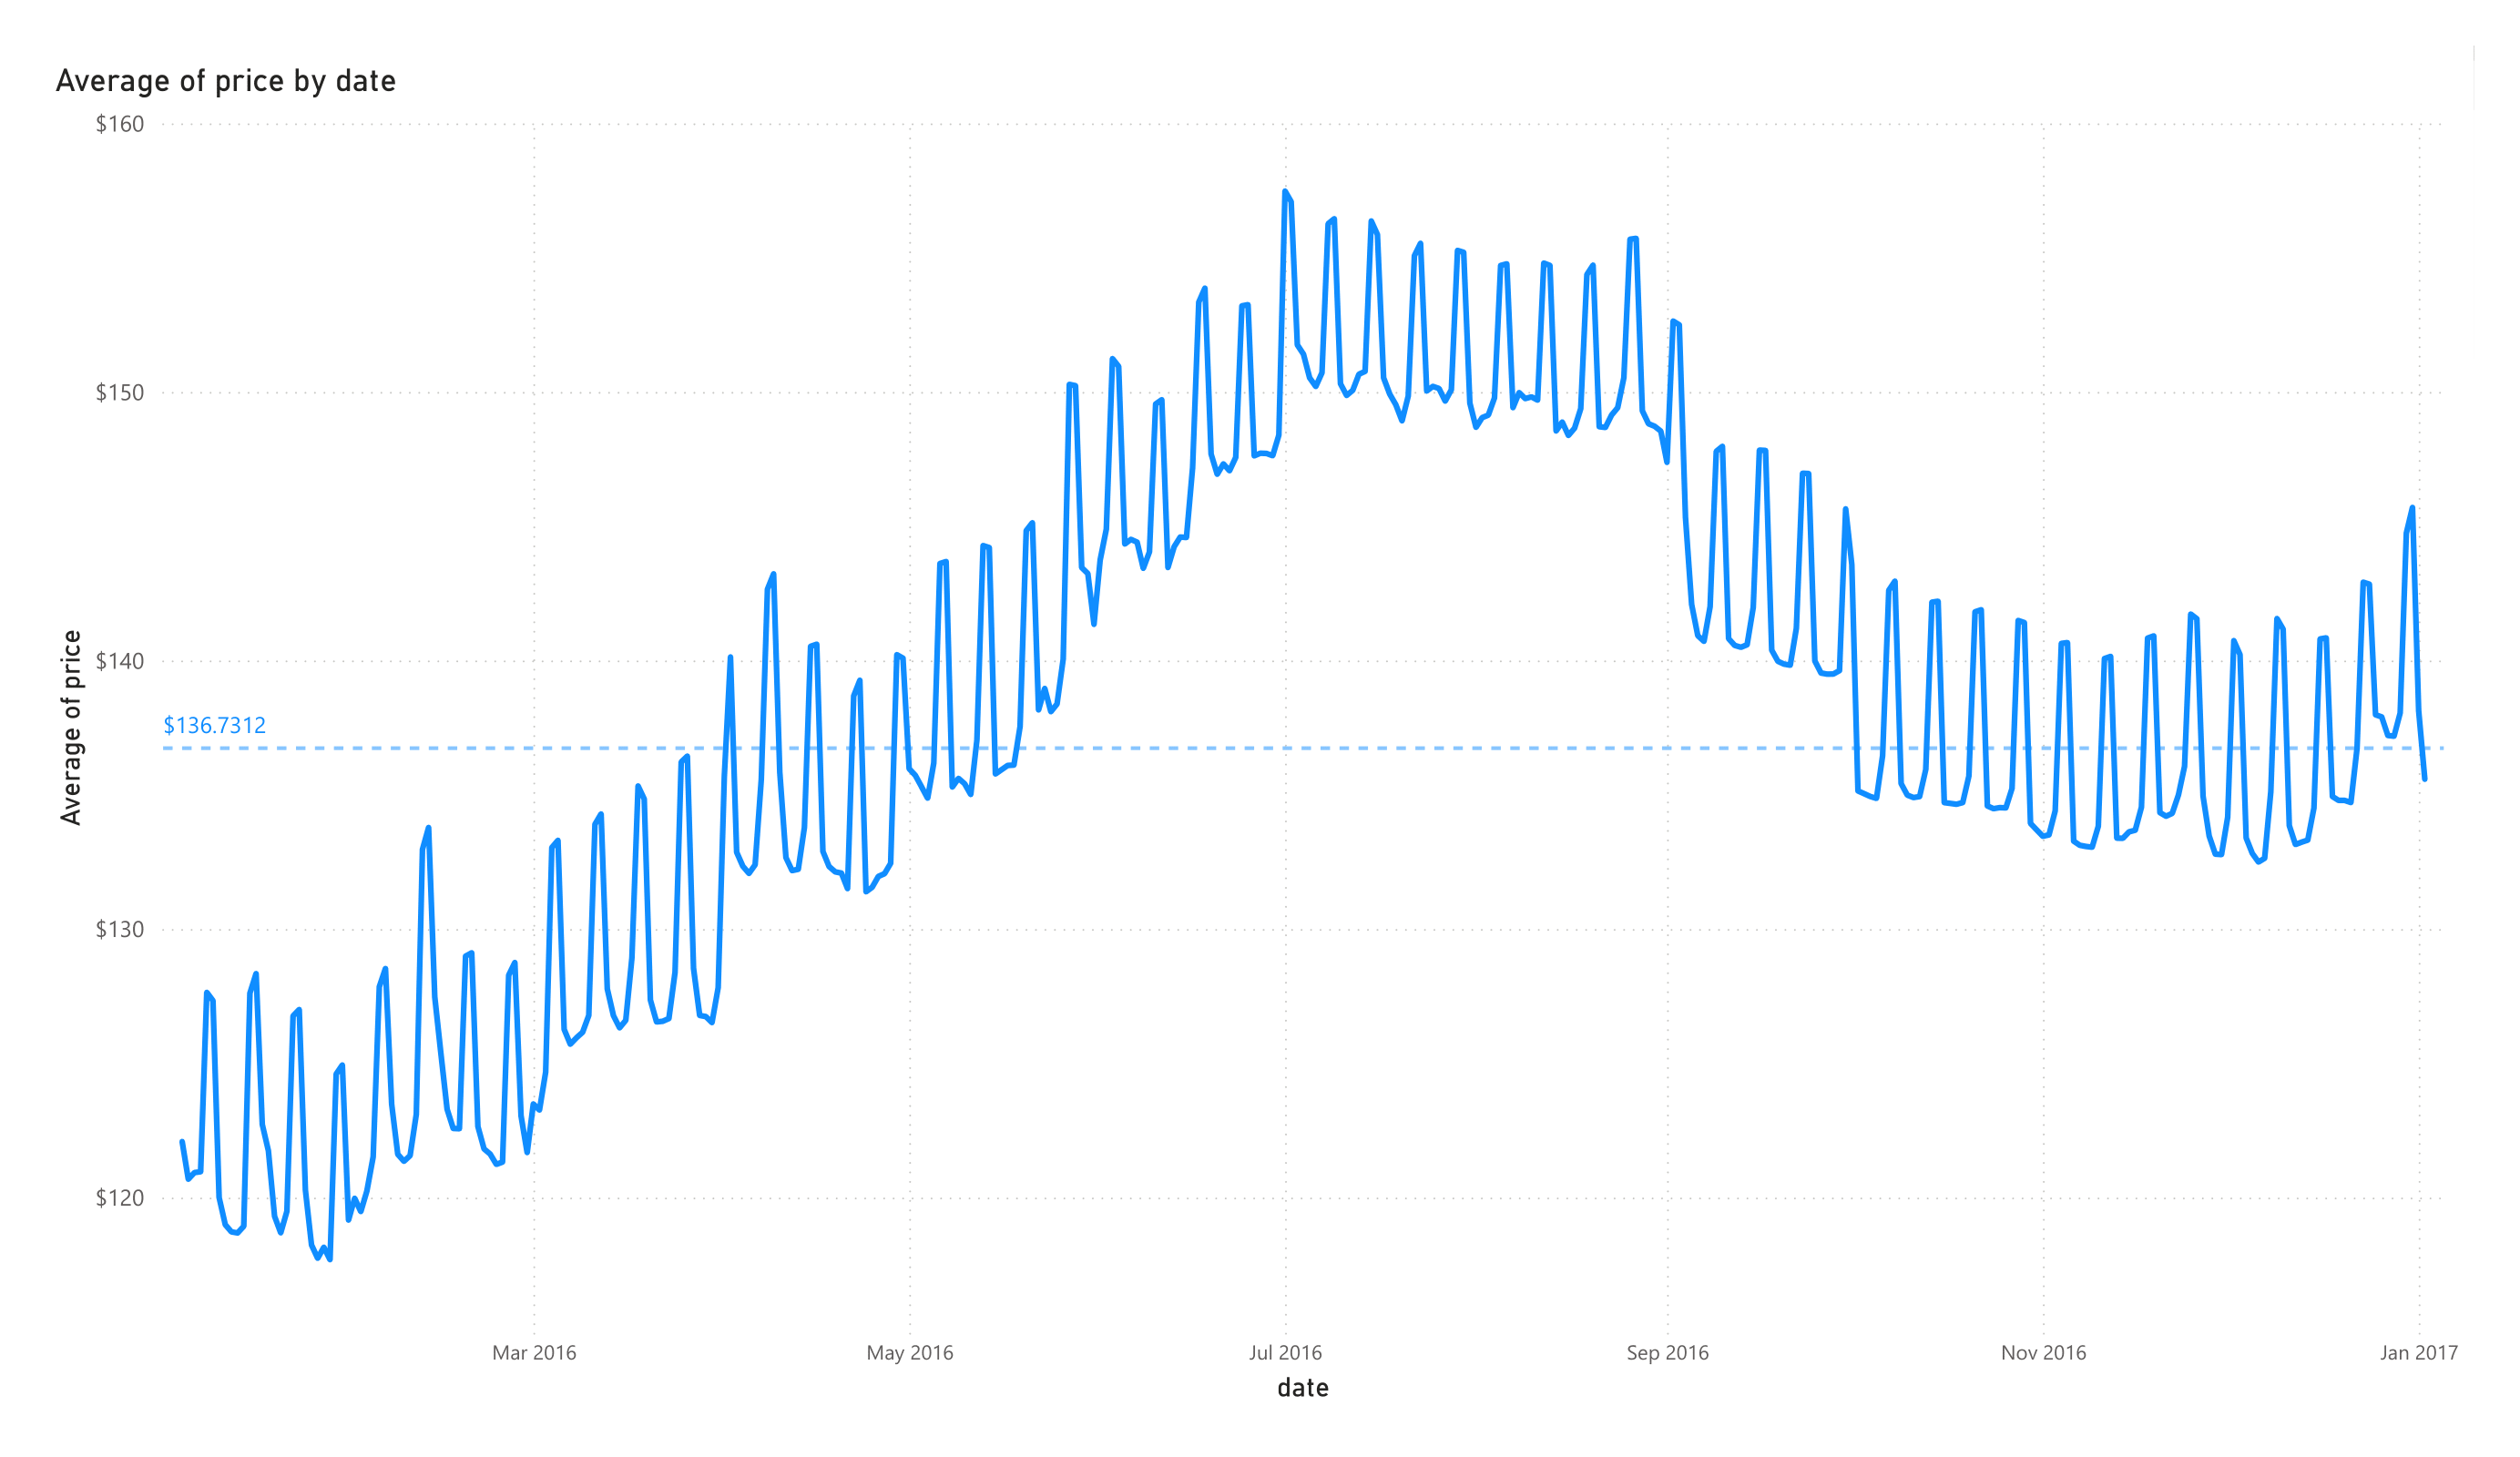

In [113]:
from IPython.display import Image, display

display(Image(filename='POWER BI-1.png'))

A2P2: as we can see, the season with the highest price hike is summer with the maximum average of the price hike to be 157.48 with the median of the year being 136.74, which is a 15.13% increase comparatively year round. This makes sense due to the most festivals and good weather happening in the summer time.

Q3:Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle? We will be using PowerIB for how laarge the data plots wwwere aand for ease of use.


This DF ids for the new amount of neew lisstings in a month

In [144]:
%%sql
SELECT
    DATE_TRUNC('month', host_since) AS month,
    COUNT(*) AS new_listings
FROM 'listings.csv' as l
GROUP BY month
ORDER BY month;

,month,new_listings
0,2008-11-01,4
1,2009-01-01,1
2,2009-02-01,2
3,2009-03-01,2
4,2009-04-01,3
...,...,...
81,2015-10-01,67
82,2015-11-01,64
83,2015-12-01,35
84,2016-01-01,5


In [141]:
%%sql
COPY (
    SELECT *
    FROM df_sql9)
TO 'SQL PowerIB3p2.csv' (FORMAT CSV, HEADER);

,Count
0,86


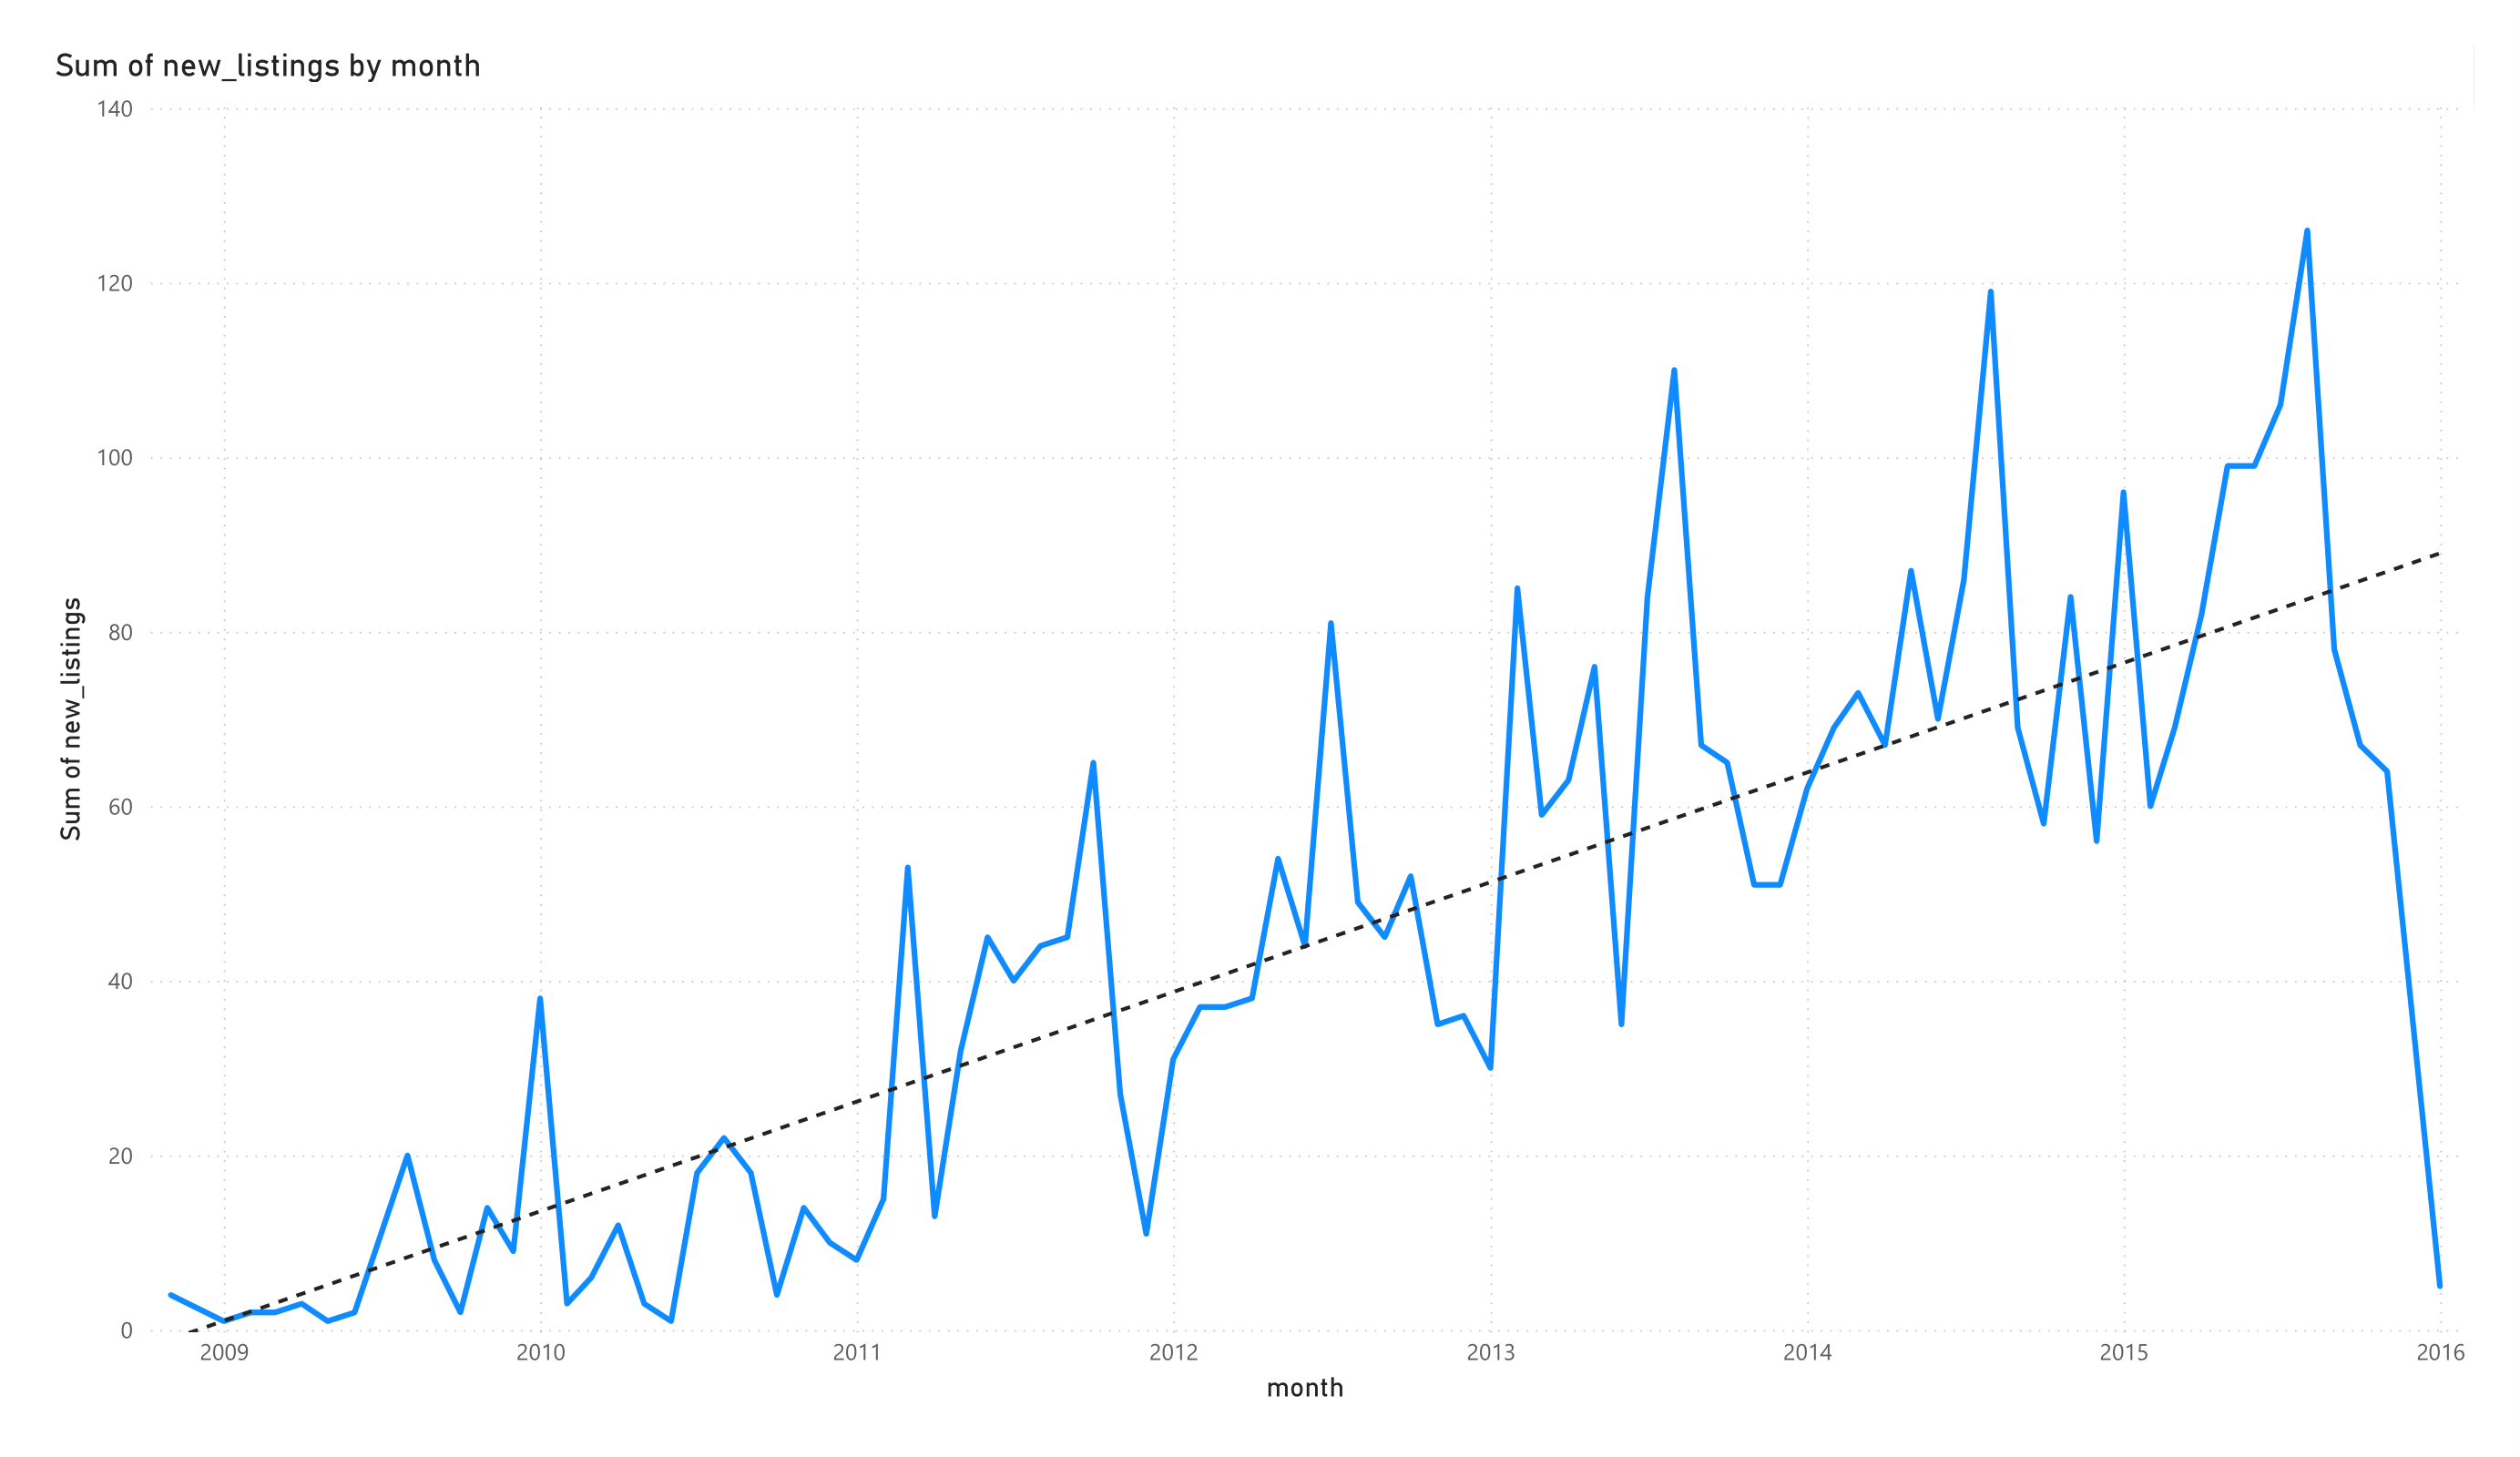

In [142]:
from IPython.display import Image, display

display(Image(filename='Untitled P1-1.png'))

A3 P1: It shows an increasing trend of new listings. One of the major factors is possibly since it is a very modern and popular city like seattle. The housing market may be extremely profitable so people may be investing more into Real Estate investments. Not to mention, during the late 2010', AirBnB was making head way for how profitable it was for owners and how cheap it was for a tourist of Seattle.

In [135]:
%%sql
SELECT
    DATE_TRUNC('month', date) AS month,
    COUNT(CASE WHEN available = 'f' THEN 1 END) AS booked_days
FROM 'calendar.csv' as c
GROUP BY month
ORDER BY month;

,month,booked_days
0,2016-01-01,47665
1,2016-02-01,37401
2,2016-03-01,34420
3,2016-04-01,38503
4,2016-05-01,38387
5,2016-06-01,37296
6,2016-07-01,44136
7,2016-08-01,42011
8,2016-09-01,37294
9,2016-10-01,35920


In [140]:
%%sql
COPY (
    SELECT *
    FROM df_sql10)
TO 'SQL PowerIB3p1.csv' (FORMAT CSV, HEADER);

,Count
0,13


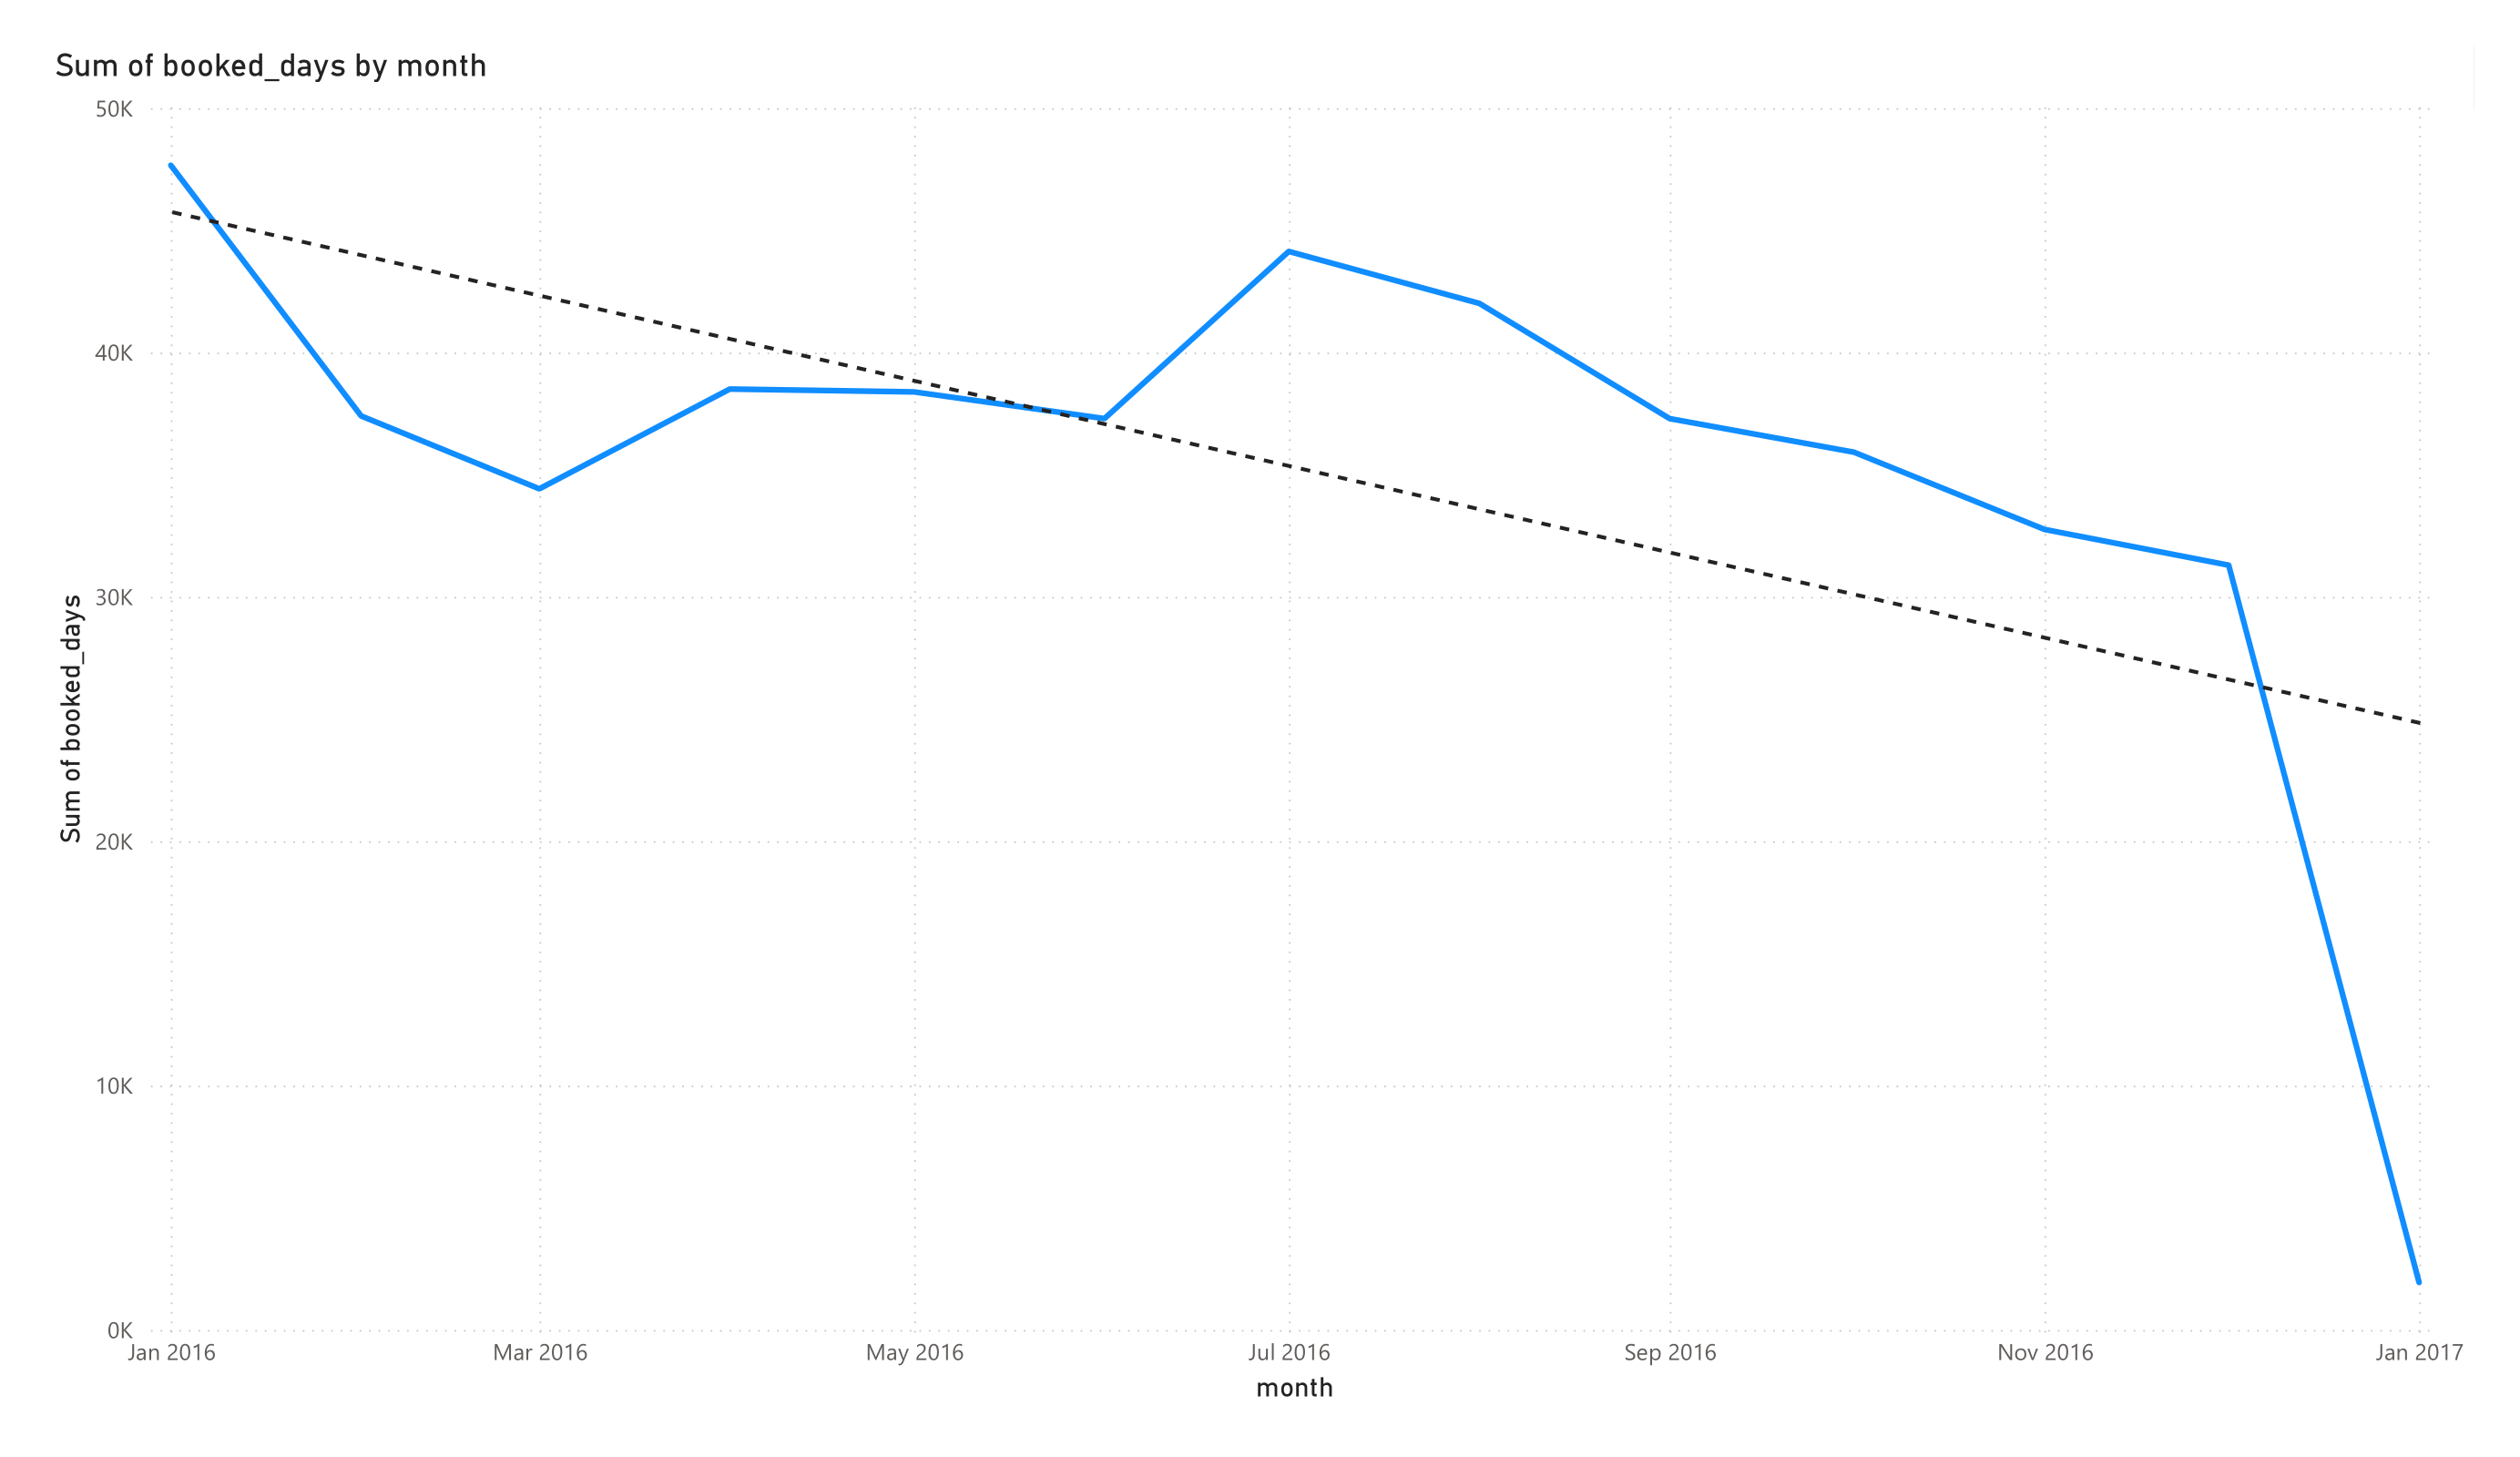

In [143]:
from IPython.display import Image, display

display(Image(filename='Untitled P2-1.png'))

A3 P2: As shown in the graph there has been a slow trend down of the number of people renting out an Airbnb. From what you can assume, people are not renting out AirBnBs due to either economic issues and seasonality. Seasonality may play a role. Think about it: if summer has higher listing prices, the owners would be ranking in more money. HOWEVER, what we seen on the graph as it goes into fall it is now at slightly above or in the middle of the avg line compared the spring prices before summer. We may see winter prices trickle down but the change will still be prevalent. Another major role is simply due economic issues, Owners have listed their Air BnBs higher due to them needing to make it economically viable, especially since it is at a large city like Seattle. Furthermore, it could also be potential benefit-cost analysis for some people if it was truly worth going to Seattle.